In [33]:
import qttk
import denali

In [34]:
run denali

In [130]:
# Options Analysis

import os
import json
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt

# Load Data
def read_json(filename:str):
    with open(filename, "r") as f:
        data = json.load(f)
        f.close()
    return data

f1 = '$SPX.X-2021-05-22-price-hist.json'
f2 = '$SPX.X-2021-05-22-opt-chain.json'

price = read_json(f1)
opt_chain = read_json(f2)

In [131]:
price.keys()

dict_keys(['candles', 'symbol', 'empty'])

In [132]:
price_df = pd.DataFrame.from_dict(price['candles'])
epoch = price_df.iloc[:,5]
price_df.iloc[:,5] = pd.to_datetime(epoch, unit='ms')
price_df = price_df.set_index(price_df.iloc[:,5])


<AxesSubplot:xlabel='datetime'>

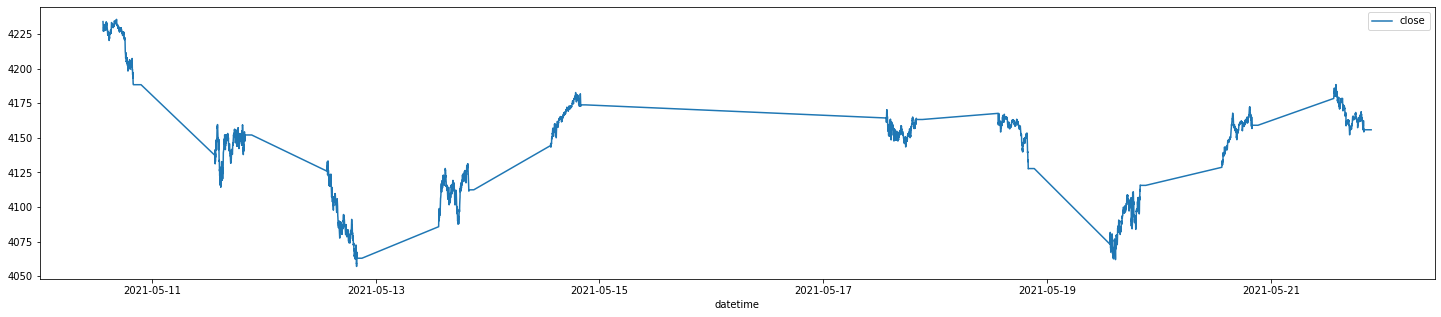

In [133]:


plt.figure(figsize=(25,5))
sea.lineplot(data=price_df[["close"]])



# Processing Option Chain

In [134]:
option_keys = [['exp','price',*nodes] for exp, info in opt_chain["callExpDateMap"].items() for values in info.values() for nodes in values][0]
call_option_data = [[exp, price, *nodes.values()] for exp, info in opt_chain["callExpDateMap"].items() for price, values in info.items() for nodes in values]
put_option_data = [[exp, price, *nodes.values()] for exp, info in opt_chain["putExpDateMap"].items() for price, values in info.items() for nodes in values]
last_price = price_df.tail(1)['close'][0]


In [227]:
#opt_chain['callExpDateMap']['2021-05-24:2']['410.0'][0]
option_df = pd.DataFrame(data=put_option_data,columns=option_keys)
option_df = option_df.append(pd.DataFrame(data=call_option_data,columns=option_keys))
option_df['price'] = pd.to_numeric(option_df['price'])
option_df['mark'] = pd.to_numeric(option_df['mark'])
option_df['last'] = pd.to_numeric(option_df['last'])
option_df[option_df['putCall'] =='PUT'].head()
option_df[option_df['putCall'] =='CALL'].head()

,exp,price,putCall,symbol,description,exchangeName,bid,ask,last,mark,...,multiplier,settlementType,deliverableNote,isIndexOption,percentChange,markChange,markPercentChange,inTheMoney,nonStandard,mini
0,2021-05-24:1,3475.0,CALL,SPXW_052421C3475,SPXW May 24 2021 3475 Call (PM) (Weekly),OPR,683.1,688.0,709.2,685.55,...,100.0,P,,None,3.77,5.13,0.75,True,False,False
1,2021-05-24:1,3500.0,CALL,SPXW_052421C3500,SPXW May 24 2021 3500 Call (PM) (Weekly),OPR,658.2,663.0,0.0,660.60,...,100.0,P,,None,0.00,5.18,0.79,True,False,False
2,2021-05-24:1,3525.0,CALL,SPXW_052421C3525,SPXW May 24 2021 3525 Call (PM) (Weekly),OPR,633.2,638.0,0.0,635.60,...,100.0,P,,None,0.00,5.18,0.82,True,False,False
3,2021-05-24:1,3550.0,CALL,SPXW_052421C3550,SPXW May 24 2021 3550 Call (PM) (Weekly),OPR,608.2,613.0,0.0,610.60,...,100.0,P,,None,0.00,5.18,0.86,True,False,False
4,2021-05-24:1,3570.0,CALL,SPXW_052421C3570,SPXW May 24 2021 3570 Call (PM) (Weekly),OPR,588.2,593.0,0.0,590.60,...,100.0,P,,None,0.00,5.18,0.88,True,False,False


# Plotting Call Skew

<AxesSubplot:xlabel='price', ylabel='mark'>

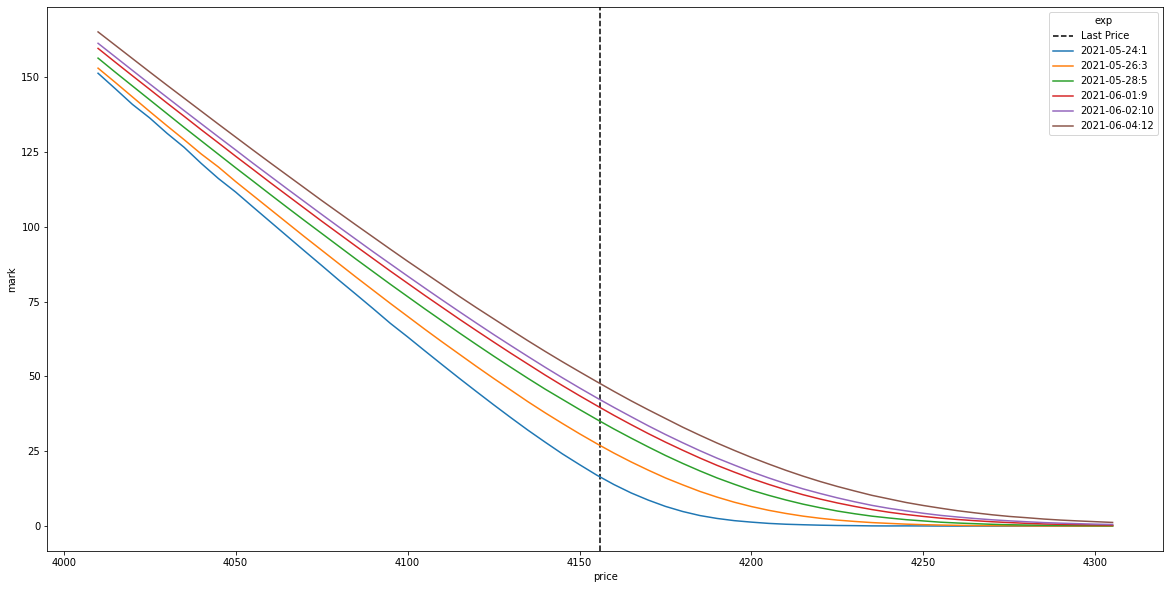

In [287]:
strike_range = 150
call_filter = (option_df['putCall'] == "CALL") 
call_skew_filter = call_filter & (option_df['price'] > last_price-strike_range) & (option_df['price'] < last_price+strike_range)
# option_df['exp'] == "2021-05-24:1") &

plt.figure(figsize=(20,10))
plt.axvline(x=last_price, ymin=0, ymax=1, label='Last Price', color='black', linestyle='--')
sea.lineplot(data=option_df[call_skew_filter],x='price',y='mark', hue='exp')


# Plotting Put Skew

<AxesSubplot:xlabel='price', ylabel='mark'>

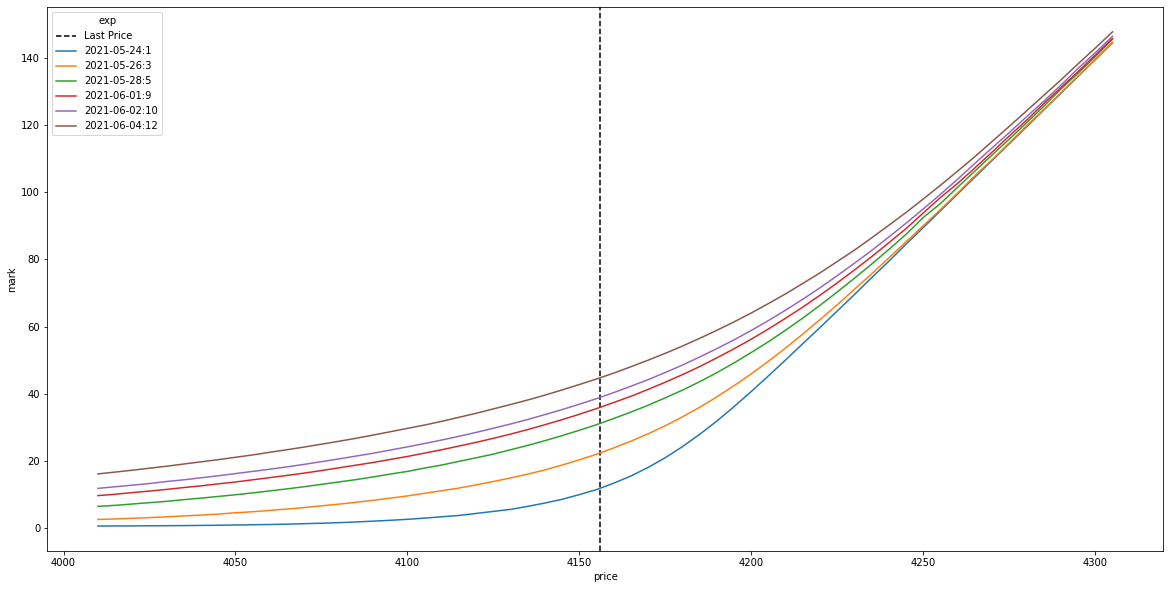

In [288]:
put_filter = (option_df['putCall'] == "PUT")
put_skew_filter = put_filter & (option_df['price'] > last_price-strike_range) & (option_df['price'] < last_price+strike_range)
# option_df['exp'] == "2021-05-24:1") &

plt.figure(figsize=(20,10))
plt.axvline(x=last_price, ymin=0, ymax=1, label='Last Price', color='black', linestyle='--')
sea.lineplot(data=option_df[put_skew_filter],x='price',y='mark', hue='exp')

# Finding Mispriced Options (Profit Opportunity!)

In [291]:
strike = 3475
strike_filter = (option_df['price'] == strike)
exp_filter = (option_df['exp'] == '2021-05-24:1' )
option_df[ put_filter & strike_filter & exp_filter]

,exp,price,putCall,symbol,description,exchangeName,bid,ask,last,mark,...,settlementType,deliverableNote,isIndexOption,percentChange,markChange,markPercentChange,inTheMoney,nonStandard,mini,parity
0,2021-05-24:1,3475.0,PUT,SPXW_052421P3475,SPXW May 24 2021 3475 Put (PM) (Weekly),OPR,0.0,0.05,0.05,0.03,...,P,,None,30600.0,0.02,24900.0,False,False,False,NaN


<AxesSubplot:xlabel='strike', ylabel='parity'>

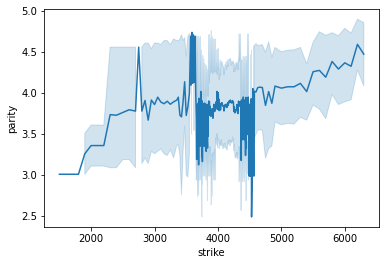

In [320]:
# We want to compare reciprocal prices for options CALL vs PUT to find gaps.
strike = 4120
strike_filter = (option_df['price'] == strike)
exp_filter = (option_df['exp'] == '2021-05-24:1' )


# Parity Formula:  C + PV(x) = P + S
# Call price + (Strike * interest) = Put Price + Current Price
#parity_df = pd.Dataframe(columns=['exp', 'strike','call_price', 'put_price', 'parity'])
parity_list = []
call_price = 0.0
put_price = 0.0
for exp in option_df['exp'].unique():
    exp_filter = (option_df['exp'] == exp )
    for strike in option_df[exp_filter]['price'].unique():
        strike_filter = (option_df['price'] == strike)
        call_price = option_df[call_filter & strike_filter & exp_filter]['mark'].apply(lambda x: x.item() if isinstance(x,pd.Series) else x)
        put_price = option_df[put_filter & strike_filter & exp_filter]['mark'].apply(lambda x: x.item() if isinstance(x,pd.Series)  else x)
        #print(f"exp: {exp} strike:{strike} type:{option_df[put_filter & strike_filter & exp_filter]}")
        #print(option_df[put_filter & strike_filter & exp_filter].values)
        #print(call_price + strike - put_price + last_price)
        parity = (call_price.item() + strike.item()) - (put_price.item() + last_price)
        parity_item = {'exp': exp, 'strike':strike,'call_price':call_price.item(), 'put_price':put_price.item() , 'last_price':last_price, 'parity':parity }
        parity_list.append(parity_item)

parity_df = pd.DataFrame(parity_list)



<AxesSubplot:xlabel='strike', ylabel='parity'>

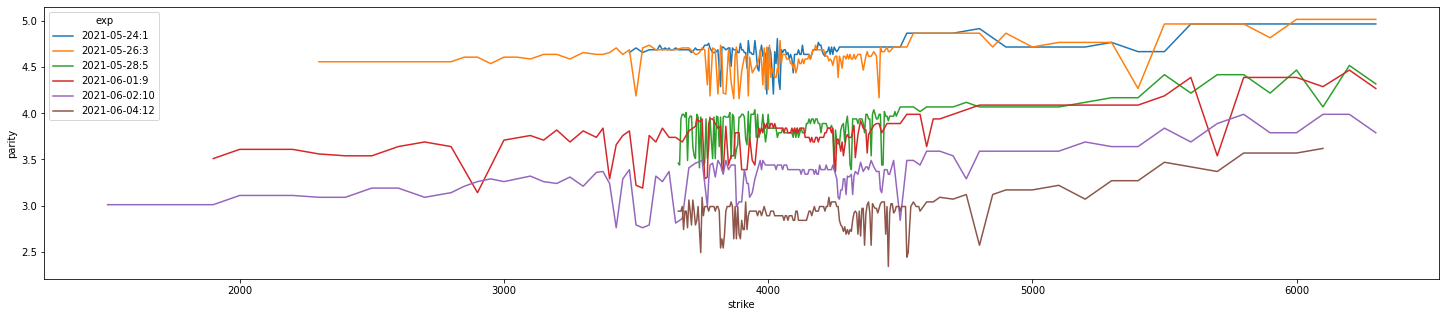

In [323]:
plt.figure(figsize=(25,5))
sea.lineplot(data=parity_df, x='strike',y='parity',hue='exp')